# Instgram Reach Forecasting

### Import Packages

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels import *
from plotly import *
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

### Load and Inspect Data 

In [75]:
df = pd.read_csv('Instagram-Reach.csv')

In [11]:
df.head()

,Date,Instagram reach
0,2022-04-01T00:00:00,7620
1,2022-04-02T00:00:00,12859
2,2022-04-03T00:00:00,16008
3,2022-04-04T00:00:00,24349
4,2022-04-05T00:00:00,20532


In [12]:
df.shape

(365, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             365 non-null    object
 1   Instagram reach  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [13]:
df.isna().sum()

Date               0
Instagram reach    0
dtype: int64

In [14]:
df.duplicated().sum()

0

In [76]:
df['Date'] = pd.to_datetime(df['Date'])

In [17]:
df.sample(5)

,Date,Instagram reach
264,2022-12-21,20108
246,2022-12-03,35159
295,2023-01-21,23006
119,2022-07-29,57778
251,2022-12-08,39843


### EDA

In [19]:
df.describe().round(1)

,Instagram reach
count,365.0
mean,50474.7
std,30051.8
min,7620.0
25%,25070.0
50%,43987.0
75%,68331.0
max,161998.0


<AxesSubplot: xlabel='Instagram reach', ylabel='Density'>

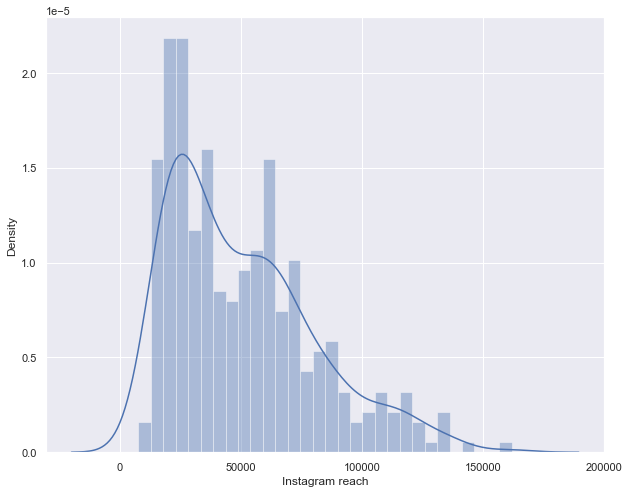

In [22]:
plt.figure(figsize=(10,8))
sns.distplot(df['Instagram reach'],bins=30)

<AxesSubplot: xlabel='Date', ylabel='Instagram reach'>

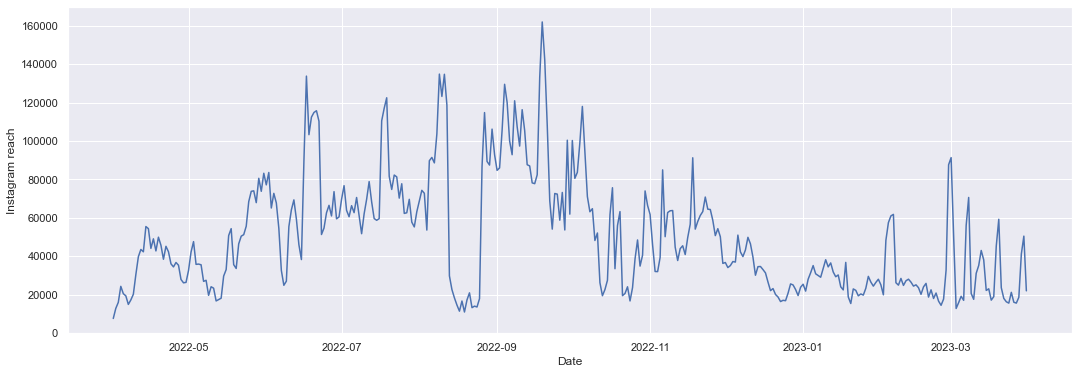

In [27]:
plt.figure(figsize=(18,6))
sns.lineplot(data=df,x='Date',y='Instagram reach')

<AxesSubplot: >

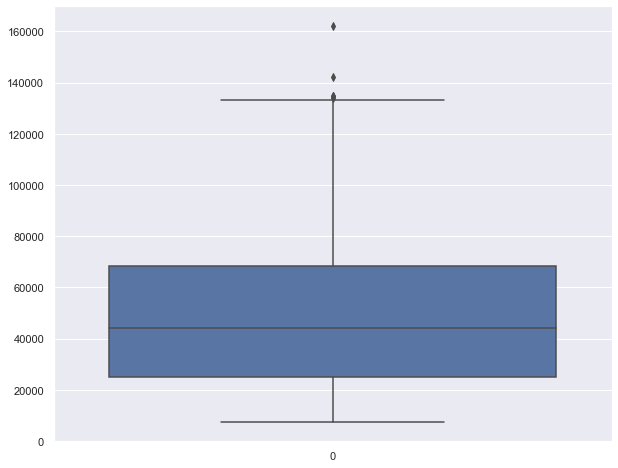

In [28]:
sns.boxplot(df['Instagram reach'])

In [77]:
df['Day'] = df['Date'].dt.day_name()
df.head()

,Date,Instagram reach,Day
0,2022-04-01,7620,Friday
1,2022-04-02,12859,Saturday
2,2022-04-03,16008,Sunday
3,2022-04-04,24349,Monday
4,2022-04-05,20532,Tuesday


In [33]:
df.groupby('Day')['Instagram reach'].agg(['mean','median','std']).reset_index()

,Day,mean,median,std
0,Friday,46666.849057,35574.0,29856.943036
1,Monday,52621.692308,46853.0,32296.071347
2,Saturday,47374.750000,40012.0,27667.043634
3,Sunday,53114.173077,47797.0,30906.162384
4,Thursday,48570.923077,39150.0,28623.220625
5,Tuesday,54030.557692,48786.0,32503.726482
6,Wednesday,51017.269231,42320.5,29047.869685


<AxesSubplot: title={'center': 'Instagram reach By Day'}, xlabel='Day', ylabel='Instagram reach'>

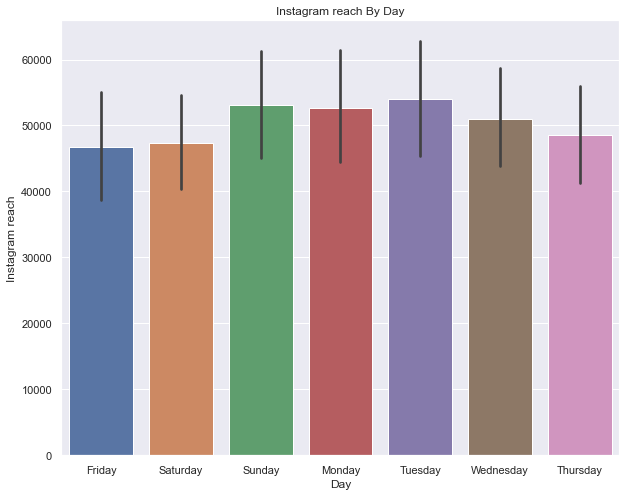

In [67]:
plt.figure(figsize=(10,8))
plt.title('Instagram reach By Day')
sns.barplot(data=df,x='Day',y='Instagram reach')

### Reach Forecasting

In [50]:

df = df[["Date", "Instagram reach"]]

result = seasonal_decompose(df['Instagram reach'], 
                            model='multiplicative', 
                            period=100)

fig = plt.figure()
fig = result.plot()


fig = mpl_to_plotly(fig)
fig.show()

<Figure size 432x288 with 0 Axes>

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

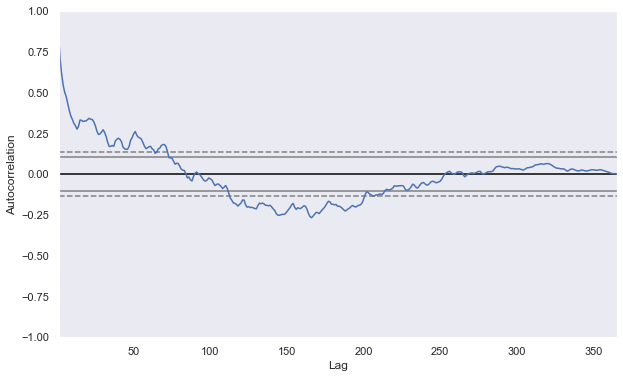

In [47]:
plt.figure(figsize=(10,6))
pd.plotting.autocorrelation_plot(df["Instagram reach"])

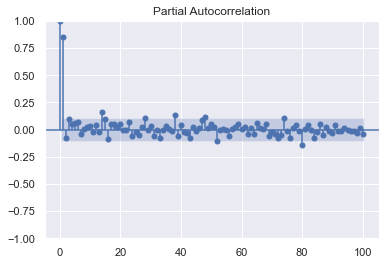

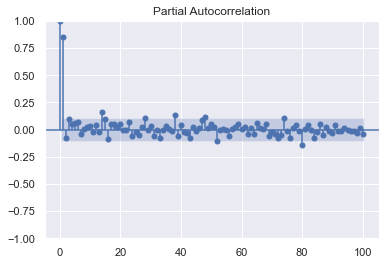

In [54]:
plot_pacf(df["Instagram reach"], lags = 100, method='ywm')

In [78]:
# train the model
p, d, q = 8, 1, 2

model=sm.tsa.statespace.SARIMAX(df['Instagram reach'], order=(p, d, q),seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    Instagram reach   No. Observations:                  365
Model:             SARIMAX(8, 1, 2)x(8, 1, 2, 12)   Log Likelihood               -3938.512
Date:                            Fri, 01 Sep 2023   AIC                           7919.024
Time:                                    22:35:59   BIC                           8000.160
Sample:                                         0   HQIC                          7951.312
                                            - 365                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1880      6.532      0.029      0.977     -12.614      12.990
ar.L2          0.4782      6.080   

In [83]:
# get predictions and visualize them


predictions = model.predict(len(df), len(df)+100)

trace_train = go.Scatter(x=df.index, 
                         y=df["Instagram reach"], 
                         mode="lines", 
                         name="Training Data")
trace_pred = go.Scatter(x=predictions.index, 
                        y=predictions, 
                        mode="lines", 
                        name="Predictions")

layout = go.Layout(title="Instagram Reach Time Series and Predictions", 
                   xaxis=dict(title="Date"), 
                   yaxis=dict(title="Instagram Reach"))

fig = go.Figure(data=[trace_train, trace_pred], layout=layout)
fig.show()